In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import sys, collections
from scipy.stats import gaussian_kde

# Load gene count matrices and get some statistics

In [37]:
dropseq = pd.read_table('../dropseq_mccarroll_out/out_gene_exon_tagged.dge.txt.gz', index_col=0)
kallisto = pd.read_table("../kallisto_mccarroll_out/v2/gene_matrix.txt", index_col=0)
salmon_in = pd.read_table("../salmon_mccarroll_out/mccarroll_symbol.csv", index_col=0, sep=',')
salmon = salmon_in.T

In [38]:
print("Genes detected in Drop-seq_tools-1.13:", len(dropseq))
print("Genes detected in kallisto bus:", len(kallisto))
print("Genes detected in salmon alevin:", len(salmon))
print("Barcodes detected in Drop-seq_tools-1.13:",len(dropseq.iloc[0,:]))
print("Barcodes detected in kallisto bus:", len(kallisto.iloc[0,:]))
print("Barcodes detected in salmon alevin:", len(salmon.iloc[0,:]))

Genes detected in Drop-seq_tools-1.13: 26124
Genes detected in kallisto bus: 20295
Genes detected in salmon alevin: 35126
Barcodes detected in Drop-seq_tools-1.13: 1000
Barcodes detected in kallisto bus: 1034
Barcodes detected in salmon alevin: 825


# Extract common barcodes and gene lists for correlation analysis

In [39]:
combine = pd.concat([dropseq, kallisto, salmon], axis=0, join='inner')

In [40]:
len(combine)

81545

In [43]:
dropseq2 = combine.iloc[0:len(dropseq),]
kallisto2 = combine.iloc[len(dropseq):(len(dropseq)+len(kallisto)),]
salmon2 = combine.iloc[(len(dropseq)+len(kallisto)):len(combine),]
dropseq_uniq = dropseq2[~dropseq2.index.duplicated(keep=False)]
kallisto_uniq = kallisto2[~kallisto2.index.duplicated(keep=False)]
salmon_uniq = salmon2[~salmon2.index.duplicated(keep=False)]
#dropseq_uniq = dropseq2[~dropseq2.index.duplicated(keep='first')]
#kallisto_uniq = kallisto2[~kallisto2.index.duplicated(keep='first')]
#salmon_uniq = salmon2[~salmon2.index.duplicated(keep='first')]

In [44]:
print(len(dropseq2),len(dropseq_uniq))
print(len(kallisto2),len(kallisto_uniq))
print(len(salmon2),len(salmon_uniq))

26124 26124
20295 19843
35126 35126


In [45]:
genes_intersect = list(set(dropseq_uniq.index) & set(kallisto_uniq.index) & set(salmon_uniq.index))

In [46]:
dropseq_intersect = dropseq_uniq.loc[genes_intersect,:]

In [47]:
kallisto_intersect = kallisto_uniq.loc[genes_intersect,:]

In [48]:
salmon_intersect = salmon_uniq.loc[genes_intersect,:]

In [49]:
print("Detected overlapping genes among Drop-seq_tools-1.13, kallisto bus & salmon alevin:", len(dropseq_intersect), len(kallisto_intersect), len(salmon_intersect))
print("Detected overlapping barcodes among Drop-seq_tools-1.13, kallisto bus & salmon alevin:", len(dropseq_intersect.iloc[0,:]), len(kallisto_intersect.iloc[0,:]), len(salmon_intersect.iloc[0,:]))

Detected overlapping genes among Drop-seq_tools-1.13, kallisto bus & salmon alevin: 17611 17611 17611
Detected overlapping barcodes among Drop-seq_tools-1.13, kallisto bus & salmon alevin: 695 695 695


# For each barcode, calculate total numbers of gene counts determined by Drop-seq, kallisto and salmon pipelines, and Pearson's correlation coefficient between Drop-seq gene counts, kallisto gene counts and salmon gene counts.

In [50]:
corr = pd.DataFrame(columns=['Pearson r1','Pearson r2','Pearson r3','Counts Dropseq', 'Counts Kallisto', 'Counts Salmon'])
for i in list(kallisto_intersect):
    corr.loc[i] = [dropseq_intersect[[i]].corrwith(kallisto_intersect[[i]])[0], 
                   dropseq_intersect[[i]].corrwith(salmon_intersect[[i]])[0], 
                   kallisto_intersect[[i]].corrwith(salmon_intersect[[i]])[0], 
                   dropseq_intersect[[i]].sum()[0], kallisto_intersect[[i]].sum()[0], salmon_intersect[[i]].sum()[0]]

In [51]:
corr[0:10]

,Pearson r1,Pearson r2,Pearson r3,Counts Dropseq,Counts Kallisto,Counts Salmon
CTTGTGCGGGAA,0.810339,0.870150,0.866893,33685.0,23463.0,40623.0
GGCCGCAGTCCG,0.828359,0.917510,0.871965,40817.0,21602.0,45222.0
GATTGGGAGGCA,0.775794,0.899793,0.860211,21340.0,14752.0,24532.0
GCGCAACTGCTC,0.798638,0.894017,0.884086,29402.0,21736.0,33605.0
AGTCAAGCCCTC,0.896212,0.914992,0.904454,19898.0,19968.0,25321.0
CCTCCTAGTTGG,0.836661,0.896118,0.878539,20273.0,16446.0,23692.0
GATTTCCTCTGA,0.810065,0.868846,0.851222,15017.0,14700.0,18220.0
CCTGTGACACAC,0.804940,0.879843,0.852971,15949.0,16601.0,19614.0
TGCGAGAGCTTG,0.887163,0.929395,0.902661,12344.0,11941.0,15038.0
TGTCCATGCGTA,0.782396,0.833375,0.848285,14734.0,13528.0,18070.0


(0, 20000)

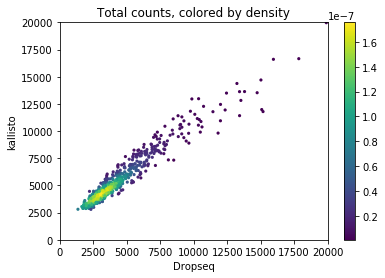

In [52]:
xy1 = np.vstack([corr.iloc[:,3], corr.iloc[:,4]])
z1 = gaussian_kde(xy1)(xy1)
plt.scatter(corr.iloc[:,3], corr.iloc[:,4], c=z1, s=10, edgecolor='')
plt.title('Total counts, colored by density')
plt.xlabel('Dropseq')
plt.ylabel('kallisto')
plt.colorbar()
plt.xlim(0,20000)
plt.ylim(0,20000)

(0, 20000)

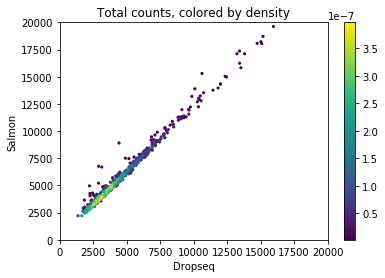

In [53]:
xy1 = np.vstack([corr.iloc[:,3], corr.iloc[:,5]])
z1 = gaussian_kde(xy1)(xy1)
plt.scatter(corr.iloc[:,3], corr.iloc[:,5], c=z1, s=10, edgecolor='')
plt.title('Total counts, colored by density')
plt.xlabel('Dropseq')
plt.ylabel('Salmon')
plt.colorbar()
plt.xlim(0,20000)
plt.ylim(0,20000)

(0, 20000)

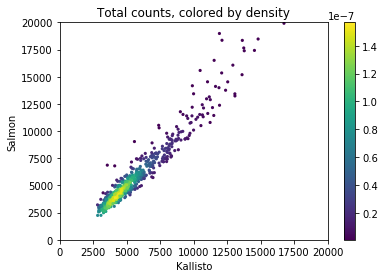

In [21]:
xy1 = np.vstack([corr.iloc[:,4], corr.iloc[:,5]])
z1 = gaussian_kde(xy1)(xy1)
plt.scatter(corr.iloc[:,4], corr.iloc[:,5], c=z1, s=10, edgecolor='')
plt.title('Total counts, colored by density')
plt.xlabel('Kallisto')
plt.ylabel('Salmon')
plt.colorbar()
plt.xlim(0,20000)
plt.ylim(0,20000)

(0, 20000)

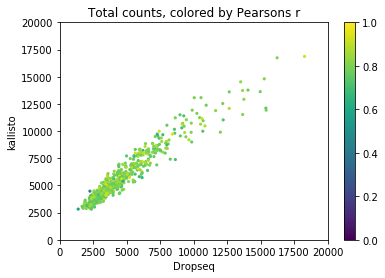

In [22]:
cm = matplotlib.cm.get_cmap('viridis')
colorlist=corr.iloc[:,0]
plt.scatter(corr.iloc[:,3], corr.iloc[:,4], c=colorlist, vmin=0, vmax=1, s=10, cmap=cm, edgecolor='')
plt.title('Total counts, colored by Pearsons r')
plt.xlabel('Dropseq')
plt.ylabel('kallisto')
plt.colorbar()
plt.xlim(0,20000)
plt.ylim(0,20000)

(0, 20000)

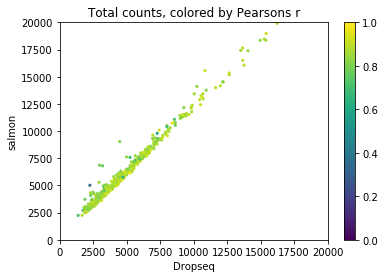

In [23]:
cm = matplotlib.cm.get_cmap('viridis')
colorlist=corr.iloc[:,1]
plt.scatter(corr.iloc[:,3], corr.iloc[:,5], c=colorlist, vmin=0, vmax=1, s=10, cmap=cm, edgecolor='')
plt.title('Total counts, colored by Pearsons r')
plt.xlabel('Dropseq')
plt.ylabel('salmon')
plt.colorbar()
plt.xlim(0,20000)
plt.ylim(0,20000)

(0, 20000)

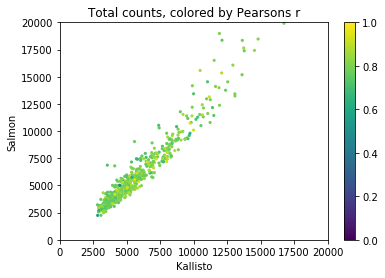

In [24]:
cm = matplotlib.cm.get_cmap('viridis')
colorlist=corr.iloc[:,0]
plt.scatter(corr.iloc[:,4], corr.iloc[:,5], c=colorlist, vmin=0, vmax=1, s=10, cmap=cm, edgecolor='')
plt.title('Total counts, colored by Pearsons r')
plt.xlabel('Kallisto')
plt.ylabel('Salmon')
plt.colorbar()
plt.xlim(0,20000)
plt.ylim(0,20000)

Pearson r1         5.563709e+02
Pearson r2         6.043360e+02
Pearson r3         5.769909e+02
Counts Dropseq     3.199401e+06
Counts Kallisto    3.899110e+06
Counts Salmon      4.077250e+06
dtype: float64